<h1 align="center"><font color = #119fbf>Detecção de Fraude de Cartão de Crédito</font></h1>

## 1 - Problema de Negócio

**Contexto** 
Um ponto de extrema importância para empresas de cartão de crédito é a capacidade de reconhecer transações fraudulentas para que os clintes não sejam cobrados por itens que não compraram. Sabendo disso, neste projeto serão utilizados algoritimos de Machine Learning para detectar transações de créditos fraudulentas.

**Dataset** 
[Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

**Sobre o conjunto de dados**
O conjunto de dados contém transações feitas por cartões de crédito em setembro de 2013 por titulares de cartões europeus.
Este conjunto de dados apresenta transações ocorridas em dois dias, onde temos **492 fraudes em 284.807 transações**. O conjunto de dados é altamente desbalanceado, a classe positiva (fraudes) responde por 0,172% de todas as transações.

As variáveis de entrada **numéricas** são o resultado de uma **transformação PCA**. Devido a questões de confidencialidade, não são fornecidos os recursos originais sobre os dados. As características V1, V2, … V28 são os principais componentes obtidos com PCA, as únicas características que não foram transformadas com PCA são 'Time' e 'Amount'. O recurso 'Time' contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. O recurso 'Amount' é o valor da transação. A característica 'Classe' é a variável de resposta e assume **valor 1 em caso de fraude e 0 caso contrário**.

<!-- (Dada a taxa de desequilíbrio de classe, é recomendado medir a precisão usando a Área sob a Curva de Rechamada de Precisão (AUPRC). A precisão da matriz de confusão não é significativa para a classificação desbalanceada.-->

**Importações**

In [231]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors	import	KNeighborsClassifier

##2 - Análise Exploratória dos Dados

**Carregando o dataset**

In [56]:
df = pd.read_csv('/content/creditcard.csv', sep=',')
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


**Informações sobre o DataFrame**

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Informações Estatísticas**

In [58]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Valores Nulos**

In [59]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Valores duplicados**

In [60]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
284802    False
284803    False
284804    False
284805    False
284806    False
Length: 284807, dtype: bool

### Visualizando algumas informações

**Verificando a ocorrência de transações fraudulentas e não fraudulentas**

In [61]:
df['Class'].unique()

array([0, 1])

In [62]:
class_copy = {0: '0 - Não Fraudulentas', 1: '1- Fraudulentas'}

df_copy = df.copy()
df_copy['Class'] = df_copy['Class'].replace(class_copy)
df_copy['Class'].value_counts()

0 - Não Fraudulentas    284315
1- Fraudulentas            492
Name: Class, dtype: int64

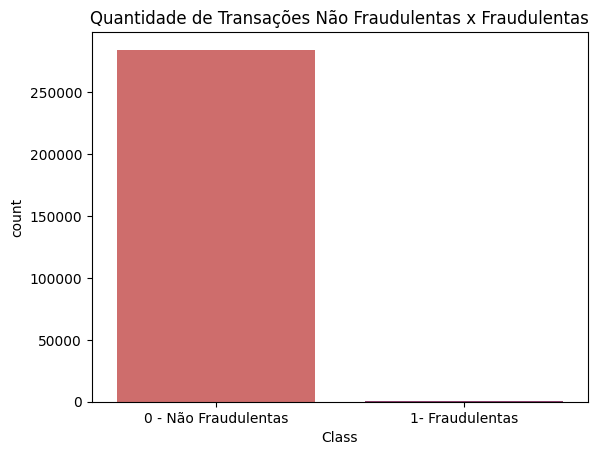

In [63]:
sns.countplot(x='Class', data=df_copy, palette="flare")
plt.title('Quantidade de Transações Não Fraudulentas x Fraudulentas');

**Verificando a correlação entre as variáveis**

In [64]:
df.corr()['Class'].sort_values(ascending=False)

Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64

In [65]:
s = df.corr()['Class'].sort_values(ascending=False)
dfs = s.to_frame()
dfs.T

,Class,V11,V4,V2,V21,V19,V20,V8,V27,V28,...,V9,V1,V18,V7,V3,V16,V10,V12,V14,V17
Class,1.0,0.154876,0.133447,0.091289,0.040413,0.034783,0.02009,0.019875,0.01758,0.009536,...,-0.097733,-0.101347,-0.111485,-0.187257,-0.192961,-0.196539,-0.216883,-0.260593,-0.302544,-0.326481


<Axes: >

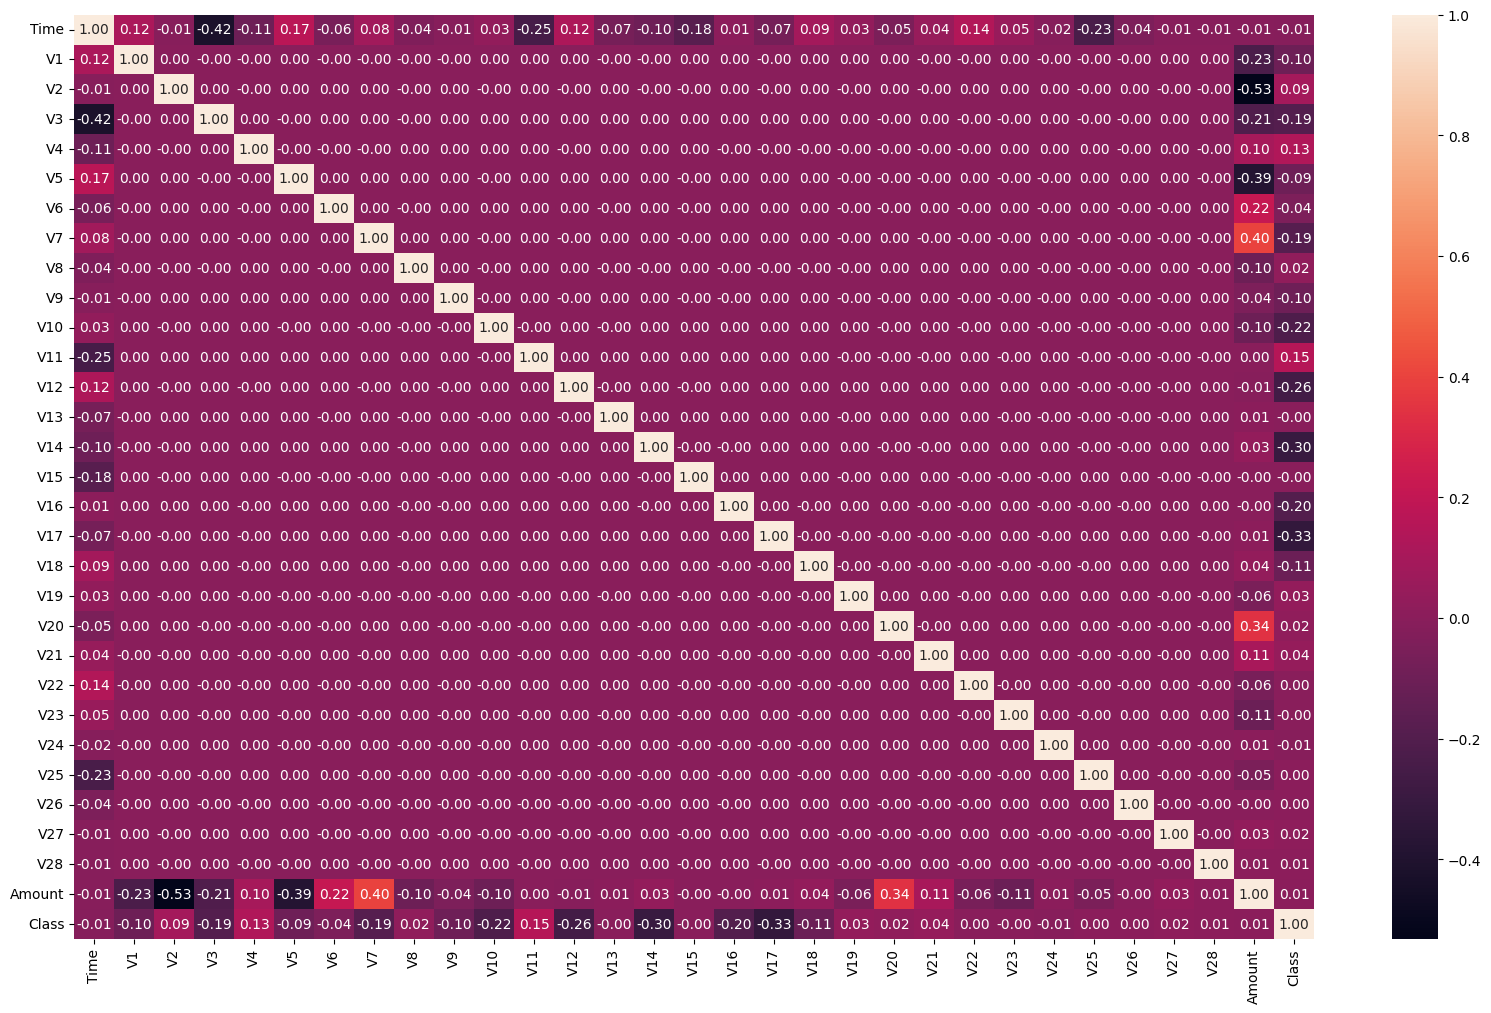

In [66]:
plt.subplots(figsize = (20,12))
sns.heatmap(df.corr(), annot = True, fmt=".2f")

**Análise das Distribuições - Tempo e Valor**

Text(0.5, 1.0, 'Distribuição do Tempo')

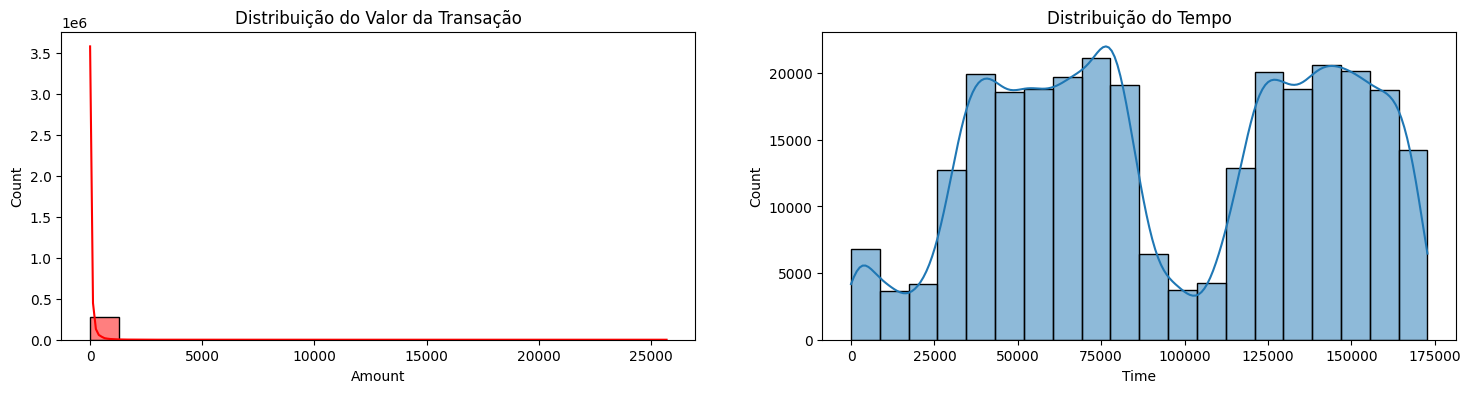

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(18,4))

sns.histplot(data=df, x='Amount', kde=True, bins=20, ax=axs[0], color='r').set_title("Distribuição do Valor da Transação")
sns.histplot(data=df, x='Time', kde=True,  ax=axs[1], bins=20).set_title("Distribuição do Tempo")

**Análise das distribuições (Tempo e Valor) em relação ao grupo de transações normais e fraudulentas**

In [68]:
df_normal = df[df['Class'] == 0]
df_fraude = df[df['Class'] == 1] 

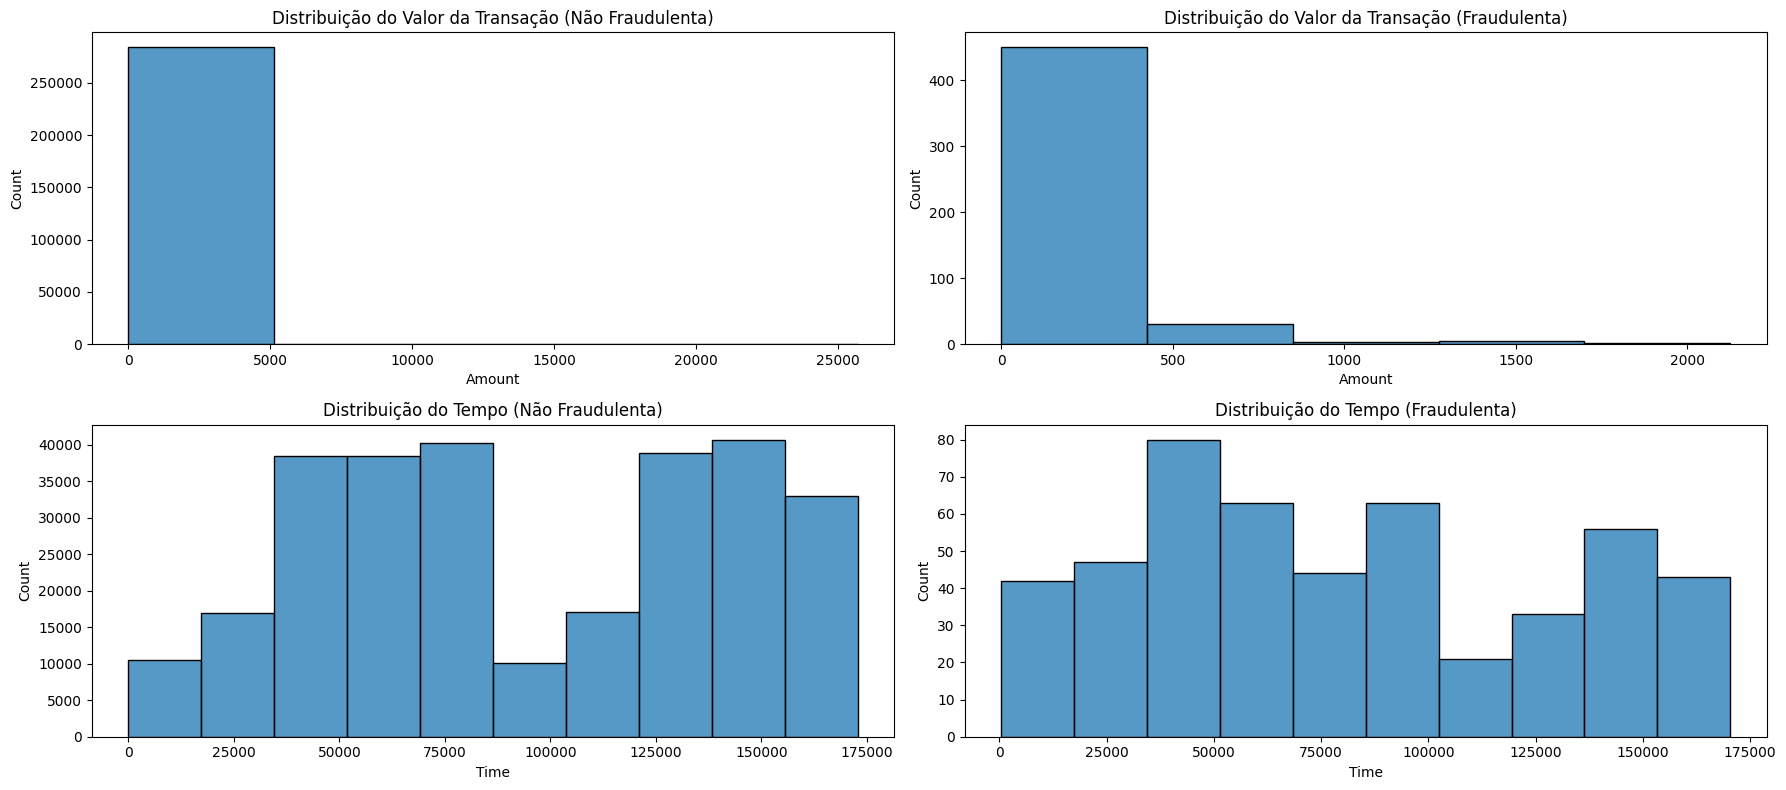

In [69]:
#fig, axs = plt.subplots(2, 1)
fig, axs = plt.subplots(2, 2, figsize=(18,8))

sns.histplot(data=df_normal, x='Amount', kde=False, bins=5, ax=axs[0][0]).set_title("Distribuição do Valor da Transação (Não Fraudulenta)");
sns.histplot(data=df_fraude, x='Amount', kde=False, bins=5, ax=axs[0][1]).set_title("Distribuição do Valor da Transação (Fraudulenta)");

sns.histplot(data=df_normal, x='Time', kde=False, bins=10, ax=axs[1][0]).set_title("Distribuição do Tempo (Não Fraudulenta)");
sns.histplot(data=df_fraude, x='Time', kde=False, bins=10, ax=axs[1][1]).set_title("Distribuição do Tempo (Fraudulenta)");

plt.tight_layout()
plt.show()

## <!--Modelagem--> 3 - Pré-processamento dos dados

**Divisão dos dados em treinamento e teste**

In [70]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=42)

In [71]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(213605, 30)
(71202, 30)
(213605,)
(71202,)


### Balanceamento dos dados

Para o balanceamento dos dados foram testadas duas técnicas: **RandomUnderSampling (RUS)** e **SMOTE**.

   * **RandomUnderSampling (RUS)** = reduz a quantidade de exemplos da classe majoritária, selecionando aleatoriamente uma amostra dos exemplos dessa classe. Isso resulta em um conjunto de dados balanceado, mas com uma quantidade reduzida de dados.
    
    
   * **SMOTE** = gera exemplos sintéticos para a classe minoritária. O SMOTE é útil quando a classe minoritária possui regiões onde há uma escassez de exemplos, e a criação de exemplos sintéticos pode preencher essas regiões.

**RandomUnderSampling (RUS)**

In [72]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [73]:
y_train_rus.value_counts()

0    369
1    369
Name: Class, dtype: int64

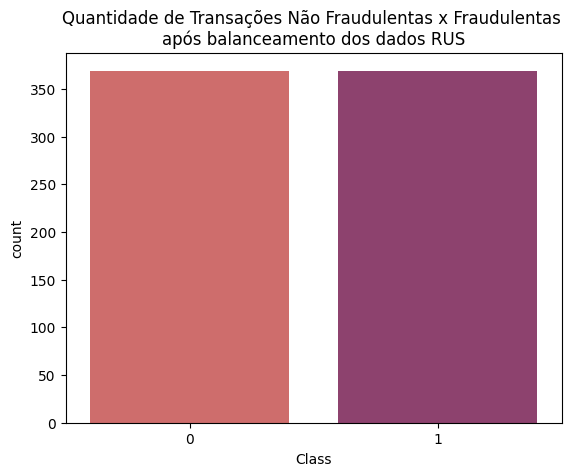

In [74]:
sns.countplot(x=y_train_rus, palette="flare")
plt.title('Quantidade de Transações Não Fraudulentas x Fraudulentas \napós balanceamento dos dados RUS');

**SMOTE**

In [75]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [76]:
y_train_smote.value_counts()

0    213236
1    213236
Name: Class, dtype: int64

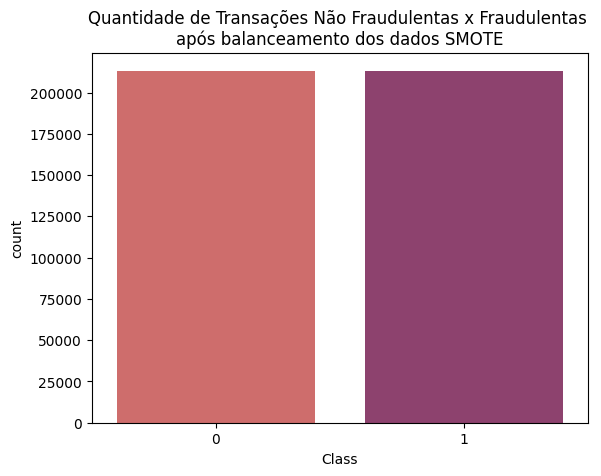

In [77]:
sns.countplot(x=y_train_smote, palette="flare")
plt.title('Quantidade de Transações Não Fraudulentas x Fraudulentas \napós balanceamento dos dados SMOTE');

## 4 - Criação dos modelos


### GridSearchCV

Auxilia na determinação de valores adequados para os hiperparâmetros e no controle da complexidade do modelo e no equilíbrio entre viés e variância.

In [78]:
def grid_search(X_train, y_train, param_grid, model):

  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
  grid_search.fit(X_train, y_train)

  print("Melhores hiperparâmetros:", grid_search.best_params_)
  print("Acurácia no conjunto de teste:", grid_search.best_estimator_.score(X_test, y_test))
  print("Melhor Pontuação de validação cruzada: ", grid_search.best_score_)

In [79]:
param_grid_tree = {'max_depth': [None, 5, 10, 15],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}

model_tree = DecisionTreeClassifier()

In [80]:
param_grid_knn = {'n_neighbors': [3, 5, 7], 
                  'weights': ['uniform', 'distance']}

model_knn = KNeighborsClassifier()

**Dados balanceados com a técnica RUS - Árvore de decisão**

In [81]:
grid_search(X_train_rus, y_train_rus, param_grid_tree, model_tree)

Melhores hiperparâmetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia no conjunto de teste: 0.9495660234263082
Melhor Pontuação de validação cruzada:  0.929555065269351


**Dados balanceados com a técnica SMOTE - Árvore de decisão**

In [82]:
grid_search(X_train_smote, y_train_smote, param_grid_tree, model_tree)

Melhores hiperparâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Acurácia no conjunto de teste: 0.9975000702227466
Melhor Pontuação de validação cruzada:  0.9988111765196133


**Dados balanceados com a técnica RUS - KNN**

In [83]:
grid_search(X_train_rus, y_train_rus,  param_grid_knn, model_knn)

Melhores hiperparâmetros: {'n_neighbors': 5, 'weights': 'distance'}
Acurácia no conjunto de teste: 0.6571865958821381
Melhor Pontuação de validação cruzada:  0.657216400073543


**Dados balanceados com a técnica SMOTE - KNN**

In [84]:
grid_search(X_train_smote, y_train_smote, param_grid_knn, model_knn)

Melhores hiperparâmetros: {'n_neighbors': 3, 'weights': 'distance'}
Acurácia no conjunto de teste: 0.9562793179966855
Melhor Pontuação de validação cruzada:  0.9681010712061122


### Treinamento dos Modelos


In [182]:
def train(X, y, model):
  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  val_acc, test_acc = [], []

  for train_index, val_index in kf.split(X, y):

      x_train, X_val = X.iloc[train_index], X.iloc[val_index]
      y_train1, y_val = y.iloc[train_index], y.iloc[val_index]
      
      model.fit(x_train, y_train1)

      test_acc.append(model.predict(X_test))

      y_val_pred = model.predict(X_val)
      val_accuracy = accuracy_score(y_val, y_val_pred)
      val_acc.append(val_accuracy)

  # Imprimir as acurácias de treinamento e validação para cada fold
  for fold, val_scores in enumerate(val_acc):
      print(f"Fold {fold+1}: ACC: {val_scores:.4f}")

  # Calcular a média das acurácias de treinamento e validação
  mean_val_accuracy = sum(val_acc) / len(val_acc)
  print(f"Média : ACC: {mean_val_accuracy:.4f}\n")

  return val_acc, test_acc

#### Decision Tree

**Treinamento usando os dados RUS**

In [129]:
model_tree_rus = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
val_acc_rus_tree, test_acc_rus_tree = train(X_train_rus, y_train_rus, model_tree_rus)

Fold 0: Acc validacao: 0.8919
Fold 1: Acc validacao: 0.9257
Fold 2: Acc validacao: 0.9324
Fold 3: Acc validacao: 0.9252
Fold 4: Acc validacao: 0.9048
Média : Acc de validacao: 0.9160



**Treinamento usando os dados SMOTE**

In [130]:
model_tree_smote = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
val_acc_smote_tree, test_acc_smote_tree = train(X_train_smote, y_train_smote, model_tree_smote)

Fold 0: Acc validacao: 0.9988
Fold 1: Acc validacao: 0.9988
Fold 2: Acc validacao: 0.9986
Fold 3: Acc validacao: 0.9986
Fold 4: Acc validacao: 0.9988
Média : Acc de validacao: 0.9987



#### KNN

**Treinamento usando os dados RUS**

In [131]:
model_knn_rus= KNeighborsClassifier(n_neighbors=5, weights='distance')
val_acc_rus_knn, test_acc_rus_knn = train(X_train_rus, y_train_rus, model_knn_rus)

Fold 0: Acc validacao: 0.6351
Fold 1: Acc validacao: 0.5676
Fold 2: Acc validacao: 0.7027
Fold 3: Acc validacao: 0.6531
Fold 4: Acc validacao: 0.6939
Média : Acc de validacao: 0.6505



**Treinamento usando os dados SMOTE**

In [132]:
model_knn_smote = KNeighborsClassifier(n_neighbors=3, weights='distance')
val_acc_smote_knn, test_acc_smote_knn = train(X_train_smote, y_train_smote, model_knn_smote)

Fold 0: Acc validacao: 0.9670
Fold 1: Acc validacao: 0.9680
Fold 2: Acc validacao: 0.9687
Fold 3: Acc validacao: 0.9679
Fold 4: Acc validacao: 0.9681
Média : Acc de validacao: 0.9679



## 5-  Avaliação dos resultados

In [227]:
def print_results(y_test, results):
    dict_results = {}
    dict_results = pd.DataFrame({
        'Acurácia': pd.Series([np.round(accuracy_score(y_test, results)*100, decimals=2)]),
        'Precisão': pd.Series([np.round(precision_score(y_test, results, average=None)*100, decimals=2)]),
        'Recall': pd.Series([np.round(recall_score(y_test, results, average=None)*100, decimals=2)]),
        'F1-Scrore': pd.Series([np.round(f1_score(y_test, results, average=None)*100, decimals=2)]),
        'AUC': pd.Series([np.round(roc_auc_score(y_test, results)*100, decimals=2)])
    })

    return pd.DataFrame(dict_results)

In [241]:
def confusion_matrix(y_true, y_pred, title):
    cm = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g').set(title=title, ylabel='True Label', xlabel='Predicted Label')

In [185]:
def roc(y_true, y_score, label):
  fpr, tpr, _ = roc_curve(y_true, y_score)

  plt.plot(fpr, tpr, label=label)
  plt.plot([0, 1], [0, 1], 'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('Taxa de Falsos Positivos (FPR)')
  plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
  plt.title('Curva ROC')
  plt.legend(loc="lower right")
  plt.show()

#### Decision Tree

**Resultados para dados de Teste - RUS**

In [233]:
predicted_rus_tree = test_acc_rus_tree[np.argmax(val_acc_rus_tree)]
df_tree_rus = print_results(y_test, predicted_rus_tree)
df_tree_rus

,Acurácia,Precisão,Recall,F1-Scrore,AUC
0,92.39,"[99.98, 2.0]","[92.4, 89.43]","[96.04, 3.9]",90.92


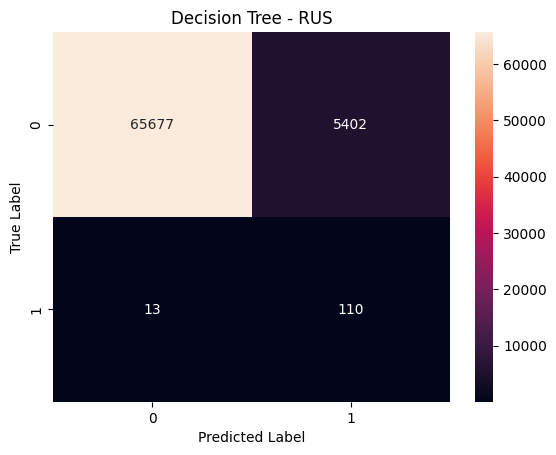

In [242]:
confusion_matrix(y_test, predicted_rus_tree, "Decision Tree - RUS")

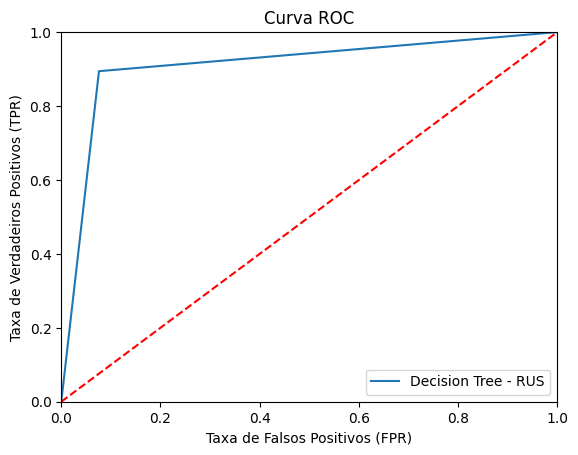

In [186]:
roc(y_test, predicted_rus_tree, "Decision Tree - RUS")

**Resultados para dados de Teste - SMOTE**

In [212]:
predicted_smote_tree = test_acc_smote_tree[np.argmax(val_acc_smote_tree)]
df_tree_smote = print_results(y_test, predicted_smote_tree)
df_tree_smote

,Acurácia,Precisão,Recall,F1-Scrore,AUC
0,99.78,"[99.97, 42.56]","[99.8, 83.74]","[99.89, 56.44]",91.77


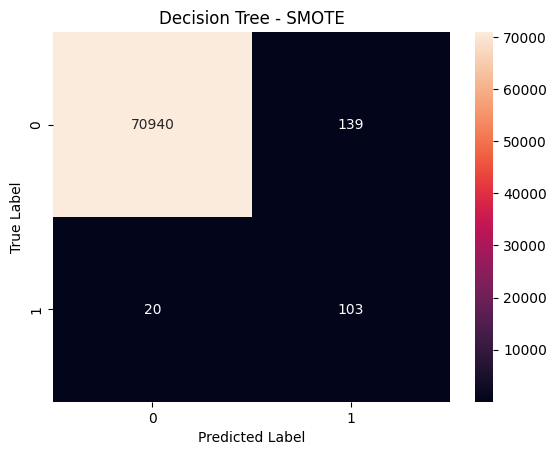

In [160]:
confusion_matrix(y_test, predicted_smote_tree, "Decision Tree - SMOTE")

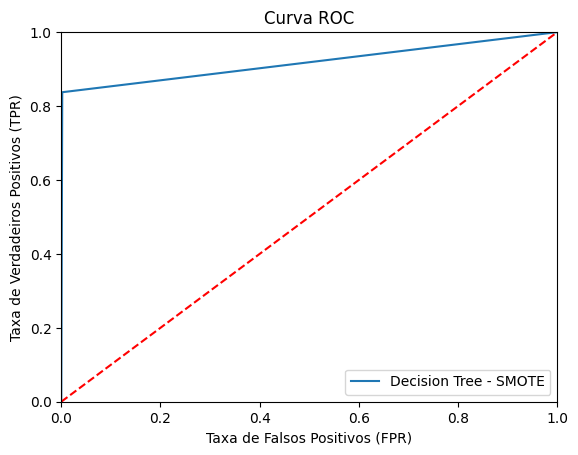

In [175]:
roc(y_test, predicted_smote_tree, "Decision Tree - SMOTE")

####  KNN

**Resultados para dados de Teste - RUS**

In [213]:
predicted_rus_knn = test_acc_rus_knn[np.argmax(val_acc_rus_knn)]
df_knn_rus = print_results(y_test, predicted_rus_knn)
df_knn_rus

,Acurácia,Precisão,Recall,F1-Scrore,AUC
0,65.03,"[99.91, 0.32]","[65.03, 65.85]","[78.78, 0.65]",65.44


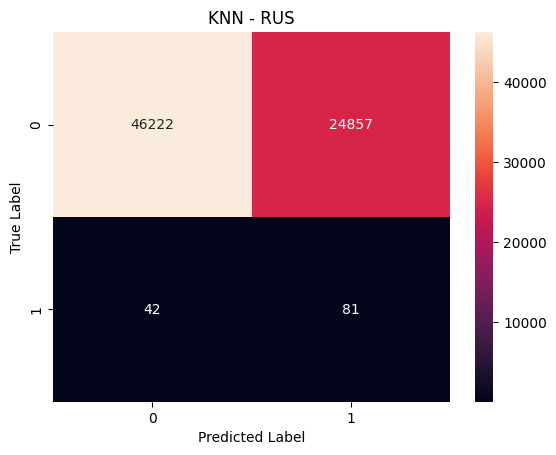

In [162]:
confusion_matrix(y_test, predicted_rus_knn, "KNN - RUS")

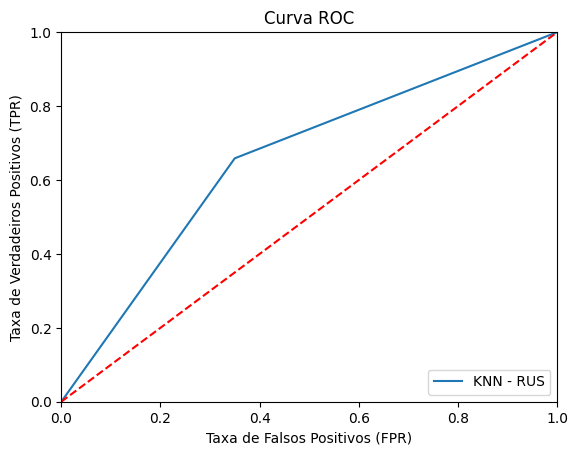

In [176]:
roc(y_test, predicted_rus_knn, "KNN - RUS")

**Resultados para dados de Teste - SMOTE**

In [214]:
predicted_smote_knn = test_acc_smote_knn[np.argmax(val_acc_smote_knn)]
df_knn_smote = print_results(y_test, predicted_smote_knn)
df_knn_smote

,Acurácia,Precisão,Recall,F1-Scrore,AUC
0,95.1,"[99.91, 1.75]","[95.18, 49.59]","[97.48, 3.38]",72.38


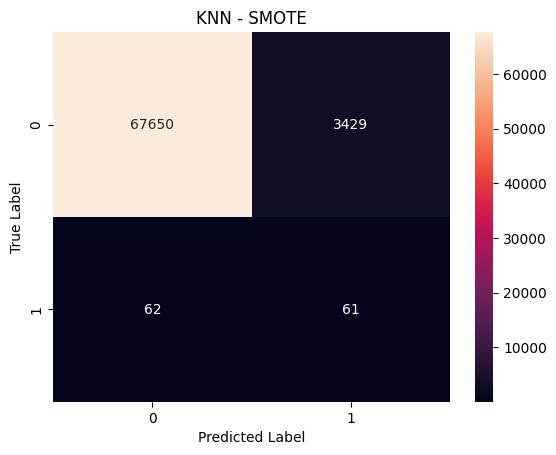

In [164]:
confusion_matrix(y_test, predicted_smote_knn, "KNN - SMOTE")

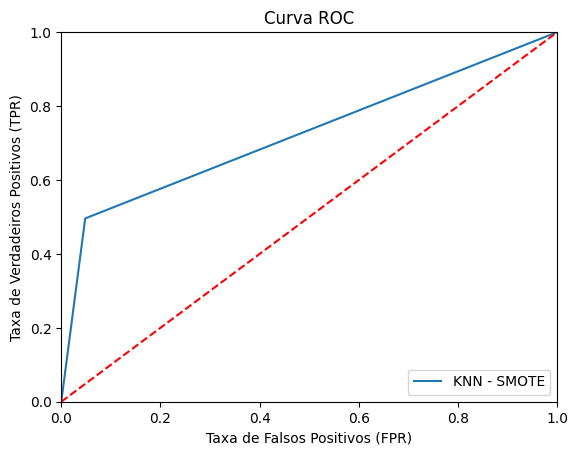

In [177]:
roc(y_test, predicted_smote_knn, "KNN - SMOTE")

####Visualizando resultados

In [215]:
df_results = pd.concat([df_tree_rus, df_tree_smote, df_knn_rus, df_knn_smote])
df_results.index = ['Decision Tree - RUS', 'Decision Tree - SMOTE', 'KNN - RUS', 'KNN - SMOTE']
df_results

,Acurácia,Precisão,Recall,F1-Scrore,AUC
Decision Tree - RUS,92.39,"[99.98, 2.0]","[92.4, 89.43]","[96.04, 3.9]",90.92
Decision Tree - SMOTE,99.78,"[99.97, 42.56]","[99.8, 83.74]","[99.89, 56.44]",91.77
KNN - RUS,65.03,"[99.91, 0.32]","[65.03, 65.85]","[78.78, 0.65]",65.44
KNN - SMOTE,95.10,"[99.91, 1.75]","[95.18, 49.59]","[97.48, 3.38]",72.38


**Comparação Matriz de Confusão**

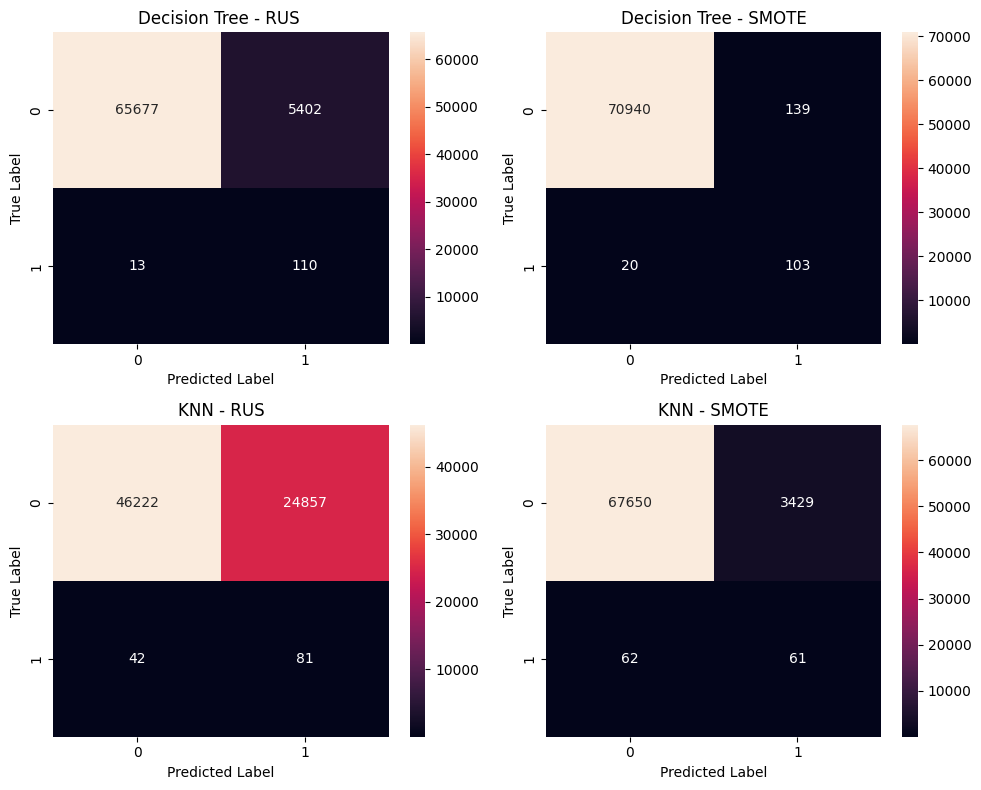

In [232]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.heatmap(confusion_matrix(y_test, predicted_rus_tree), annot=True, fmt='g', ax=axs[0][0]).set(title='Decision Tree - RUS ', ylabel='True Label', xlabel='Predicted Label')
sns.heatmap(confusion_matrix(y_test, predicted_smote_tree), annot=True, fmt='g', ax=axs[0][1]).set(title='Decision Tree - SMOTE', ylabel='True Label', xlabel='Predicted Label')
sns.heatmap(confusion_matrix(y_test, predicted_rus_knn), annot=True, fmt='g', ax=axs[1][0]).set(title='KNN - RUS', ylabel='True Label', xlabel='Predicted Label')
sns.heatmap(confusion_matrix(y_test, predicted_smote_knn), annot=True, fmt='g', ax=axs[1][1]).set(title='KNN - SMOTE', ylabel='True Label', xlabel='Predicted Label')

plt.tight_layout()
plt.show()

**Comparação Curva ROC**

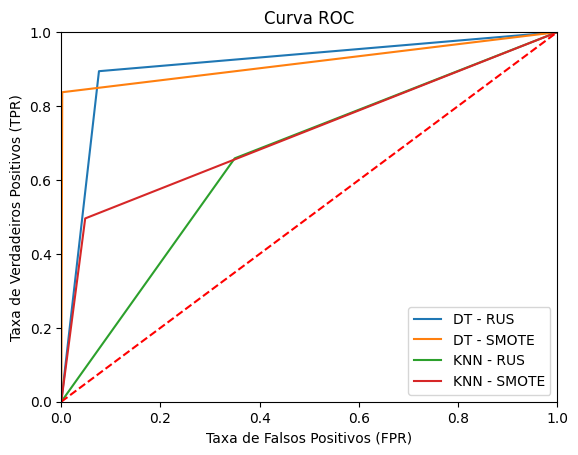

In [171]:
fpr_rus_tree, tpr_rus_tree, _ = roc_curve(y_test, predicted_rus_tree)
fpr_smote_tree, tpr_smote_tree, _ = roc_curve(y_test, predicted_smote_tree)

fpr_rus_knn, tpr_rus_knn, _ = roc_curve(y_test, predicted_rus_knn)
fpr_smote_knn, tpr_smote_knn, _ = roc_curve(y_test, predicted_smote_knn)

plt.plot(fpr_rus_tree, tpr_rus_tree, label='DT - RUS')
plt.plot(fpr_smote_tree, tpr_smote_tree, label='DT - SMOTE')
plt.plot(fpr_rus_knn, tpr_rus_knn, label='KNN - RUS')
plt.plot(fpr_smote_knn, tpr_smote_knn, label='KNN - SMOTE')

plt.plot([0, 1], [0, 1], 'r--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()